In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
# import sklearn.mixture as sm
from scipy.special import logsumexp
import emcee

# import myutils
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
R

array([[ 6.17315107e-01, -9.38267154e-03, -7.86660043e-01],
       [-1.51801852e-02, -9.99884774e-01,  1.35163174e-05],
       [-7.86569527e-01,  1.19333013e-02, -6.17386407e-01]])

In [6]:
for i in range(3):
    print('{:.10f} & {:.10f} & {:.10f} \\\\'.format(R[i][0], R[i][1], R[i][2]))

0.6173151074 & -0.0093826715 & -0.7866600433 \\
-0.0151801852 & -0.9998847743 & 0.0000135163 \\
-0.7865695266 & 0.0119333013 & -0.6173864075 \\


In [7]:
f = open('../paper/rotmat.tex', 'w')
for i in range(3):
    f.write('{:.10f} & {:.10f} & {:.10f} \\\\ \n'.format(R[i][0], R[i][1], R[i][2]))
f.close()

In [8]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

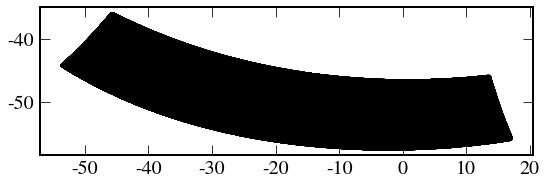

In [9]:
plt.plot(coord.Angle(t['ra']*u.deg).wrap_at(180*u.deg), t['dec'], 'k.', rasterized=True)
plt.gca().set_aspect('equal')
plt.tight_layout()

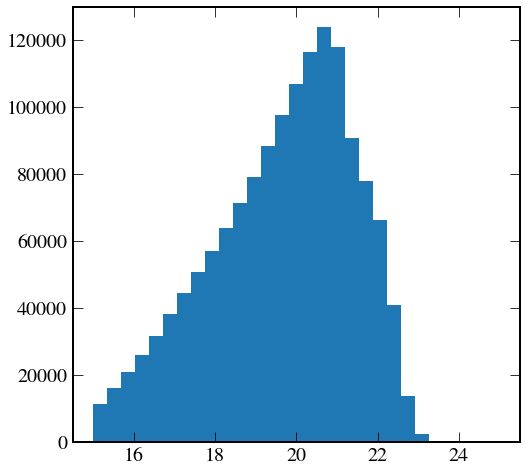

In [10]:
plt.hist(t['g'], bins=np.linspace(15,25,30));

In [11]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

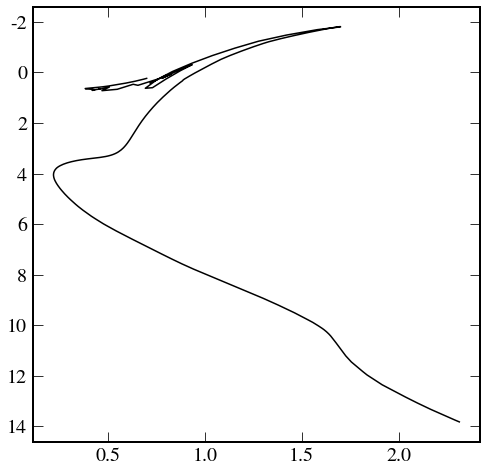

In [12]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<4)
iso = iso[phasecut]

plt.plot(iso['DECam_g'] - iso['DECam_i'], iso['DECam_g'], 'k-')

plt.gca().invert_yaxis()

In [13]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [14]:
wangle = 180*u.deg

In [97]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p2-p1)
    return (m*(phi1.wrap_at(wangle).value - p1) + d1) * u.kpc

In [16]:
# adopt 13kpc
d0 = 13
d1 = 0
d2 = 0

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [17]:
# masks
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (((cj.phi2<-3.5*u.deg) & (cj.phi2>-4*u.deg)) | ((cj.phi2<4*u.deg) & (cj.phi2>3.5*u.deg)) &
                (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg))

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

bhb_gi_min = -0.7
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5
bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

poly_bs = np.array([[0.2,18.9], [0.2, 19.9], [-0.25, 18.7], [-0.25,17.7]])
path_bs = mpl.path.Path(poly_bs)
bs_mask = path_bs.contains_points(points)

In [18]:
np.sum(cmd_mask & pm_mask)

6424

## Define stream tracks

In [19]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [20]:
# setup bins for finding track
bin_size = 3 # deg
bins = np.arange(-5, 25+bin_size, bin_size)
bincen = 0.5 * (bins[1:] + bins[:-1])

In [21]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (cj.phi2 < 1.5*u.deg) & (cj.phi2 > -0.1*u.deg)

phi2_median, be, bn = scipy.stats.binned_statistic((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       cj.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins)
phi2_sum, be = np.histogram((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(bincen, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-5, 25, 100)
phi2_ = polytrack(phi1_)

In [22]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
narrow_mask = phi1_mask & (np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg)<=0.4*u.deg)
wide_mask = (phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<-0.4*u.deg)
             & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>-2.*u.deg))

In [23]:
polytrack

poly1d([ 5.45507585e-04, -2.16665231e-03,  5.82737370e-01])

In [24]:
eq_track = '\phi_2 = {:.3g} \,\phi_1^2 {:+.3g} \,\phi_1 {:+.3g}'.format(*ptrack)
eq_track

'$\\phi_2 = 0.000546 \\,\\phi_1^2 -0.00217 \\,\\phi_1 +0.583$'

In [25]:
f = open('../paper/polytrack.tex', 'w')
f.write(eq_track)
f.close()

## Figure: Map

### Number density

In [221]:
dp = 0.05
bx = np.arange(-10, 30+dp, dp)
by = np.arange(-5, 5+dp, dp)

In [222]:
h, bx, by = np.histogram2d(cj.phi1.wrap_at(wangle).deg, cj.phi2.deg, bins=(bx, by))
h = (h * ((dp*u.deg).to(u.arcmin))**-2).value

### Dust map

In [223]:
from dustmaps.sfd import SFDQuery

In [224]:
dp = 0.05
dp1 = np.arange(-10, 30+dp, dp)
dp2 = np.arange(-5, 5+dp, dp)
dp1, dp2 = np.meshgrid(dp1, dp2)
cdust = Jhelum(dp1*u.deg, dp2*u.deg, distance=13*u.kpc)
cdust_eq = cdust.transform_to(coord.Galactic)
cdust_sc = coord.SkyCoord(cdust_eq.l, cdust_eq.b, frame='galactic')

In [225]:
sfd = SFDQuery()
Av_sfd = 2.742 * sfd(cdust_sc)

### Fit the histogram

In [204]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def lnprior(p):
    a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = p
    
    lp = 0
    
    fs = [a1, a2]
    for f in fs:
        if f < 0 or f > 1:
            return -np.inf
    
    if a2 < a1:
       return -np.inf
    
    if sum(fs) > 1:
        return -np.inf
    
    if mu1 < -4 or mu1 > 4 or mu2 < -4 or mu2 > 4:
        return -np.inf
    
    if lnabg > 0:
        return -np.inf
    
    lp += lnnormal(lnstd1, -1, 5)
    lp += lnnormal(lnstd2, -1, 5)
    
    return lp

def lnlike(p, phi2):
    a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = p
    a_bg = 1 - a1 - a2
    
    component1 = lnnormal(phi2, mu1, np.exp(lnstd1))
    component2 = lnnormal(phi2, mu2, np.exp(lnstd2))
#     bg = np.full_like(component1, -np.log(5 - -5))
    bg = np.log(np.exp(lnabg) * phi2 + 1/(5 - -5)) # to normalize over phi_2 = -5 to 5
    
    return logsumexp([component1, component2, bg], b=np.array([a1, a2, a_bg])[:, None], axis=0)

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf
    
    ll = lnlike(p, phi2)
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return ll.sum() + lp

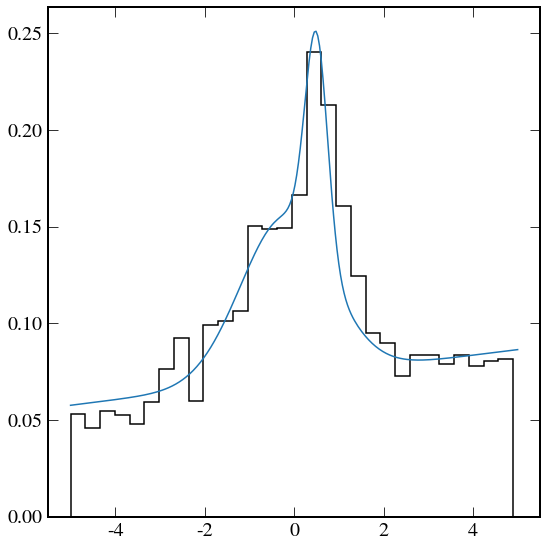

In [205]:
bins = np.arange(-5, 5+1e-3, 0.33)

p0s = [0.07, 0.21, # a1, a2
       0.5, -0.2, # mu1, mu2, 
       np.log(0.25), np.log(1), np.log(4e-3)] #lnstd_s1, lnstd_s2,
    
phi2_grid = np.linspace(-5, 5, 256)

plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
         bins=bins, histtype='step', lw=1.5, normed=True, color='k')

plt.plot(phi2_grid, np.exp(lnlike(p0s, phi2_grid)))

plt.tight_layout()

In [214]:
nwalkers = 64
nsteps = 4096
# nsteps = 512

p0 = emcee.utils.sample_ball(p0s, [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3], nwalkers)
p0[:,:2] = np.abs(p0[:,:2])
p0[:,-1] = -np.abs(p0[:,-1])

sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], threads=2,
                                lnpostfn=lnprob, args=(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, ))
_ = sampler.run_mcmc(p0, nsteps)


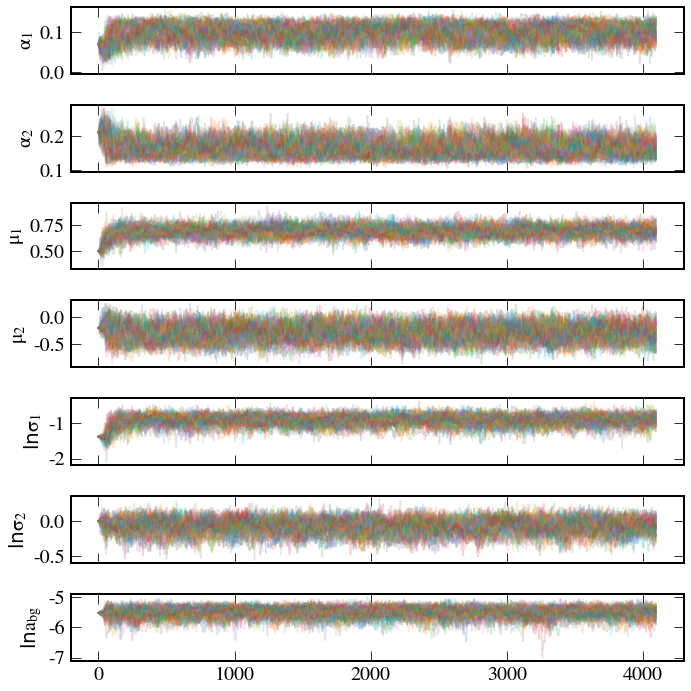

In [215]:
names = [r'$\alpha_{1}$', r'$\alpha_{2}$',  
         r'$\mu_1$', r'$\mu_2$',
         r'$\ln\sigma_{1}$', r'$\ln\sigma_{2}$', r'$\ln a_{bg}$']

fig, axes = plt.subplots(sampler.dim,
                         figsize=(10,10), 
                         sharex=True)
    
for k in range(sampler.dim):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

for i in range(len(names)):
    axes[i].set_ylabel(names[i])
            
fig.tight_layout()

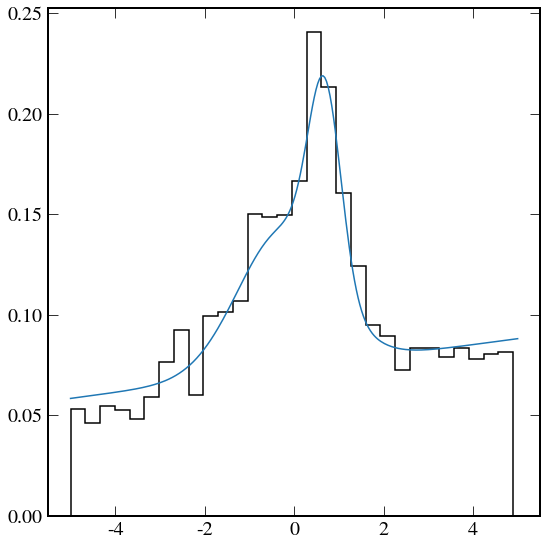

In [216]:
idx = sampler.lnprobability[:, -1].argmax()
show_p = sampler.chain[idx, -1]

plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
         bins=bins, histtype='step', lw=1.5, normed=True, color='k')

plt.plot(phi2_grid, np.exp(lnlike(show_p, phi2_grid)))

plt.tight_layout()

In [229]:
a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = sampler.flatchain[2048:].T # discard burn-in
std1 = np.exp(lnstd1)
std2 = np.exp(lnstd2)
w1 = (np.tan((std1*u.deg).to(u.rad))*13*u.kpc).to(u.pc)
w2 = (np.tan((std2*u.deg).to(u.rad))*13*u.kpc).to(u.pc)
a_bg = 1 - (a1+a2)

p_units = [u.Unit(1), u.Unit(1), u.deg, u.deg, u.deg, u.deg, u.pc, u.pc]
p_names = names[:-3] + [r'$\sigma_1$', r'$\sigma_2$',r'$w_1$', r'$w_2$']
for e, i in enumerate([a1, a2, mu1, mu2, std1, std2, w1, w2]):
    _l, _m, _u = np.percentile(i, [16,50,64])
    print('{:s} = {:.3g} + {:.3g} - {:.3g} {:s}'.format(p_names[e], _m, _u-_m, _m-_l, p_units[e]))

$\alpha_{1}$ = 0.102 + 0.00809 - 0.024 
$\alpha_{2}$ = 0.161 + 0.0101 - 0.0222 
$\mu_1$ = 0.693 + 0.0173 - 0.0499 deg
$\mu_2$ = -0.311 + 0.0636 - 0.162 deg
$\sigma_1$ = 0.403 + 0.0188 - 0.0576 deg
$\sigma_2$ = 0.937 + 0.036 - 0.103 deg
$w_1$ = 91.5 + 4.27 - 13.1 pc
$w_2$ = 213 + 8.17 - 23.3 pc


In [258]:
out_names = ['a1', 'a2', 's1', 's2', 'w1', 'w2']
out_label = ['\\alpha', '\\alpha', '\sigma', '\sigma', 'w', 'w']
out_ind = [1,2,1,2,1,2]
for e, i in enumerate([a1, a2, std1, std2, w1, w2]):
    _l, _m, _u = np.percentile(i, [16,50,64])
    if e<2:
        out = '${:s}_{{{:}}} = {:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(out_label[e], out_ind[e], _m,_u-_m,_m-_l)
    elif e<4:
        out = '${:s}_{{{:}}} = {:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$'.format(out_label[e], out_ind[e], _m,_u-_m,_m-_l)
    else:
        out = '${:s}_{{{:}}} = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}}$'.format(out_label[e], out_ind[e], _m,_u-_m,_m-_l)
    print(out)
    f = open('../paper/{}.tex'.format(out_names[e]), 'w')
    f.write(out)
    f.close()

$\alpha_{1} = 0.102^{+0.008}_{-0.024}$
$\alpha_{2} = 0.161^{+0.010}_{-0.022}$
$\sigma_{1} = 0.40^{+0.02}_{-0.06}$
$\sigma_{2} = 0.94^{+0.04}_{-0.10}$
$w_{1} = 91^{+4}_{-13}$
$w_{2} = 213^{+8}_{-23}$


### Plot figure 2

/home/ana/install/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


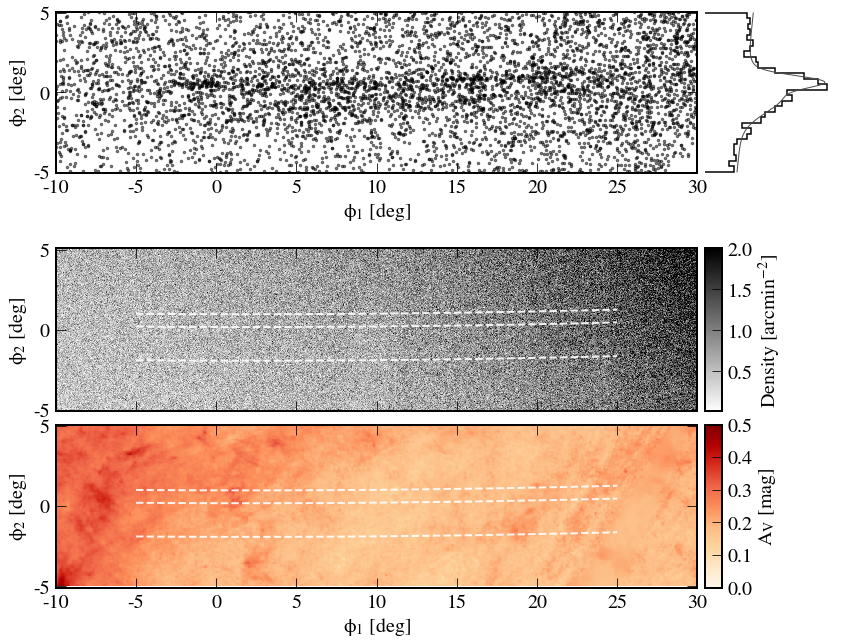

In [227]:
fig = plt.figure(figsize=(12,10))

# setup gridspec
gs0 = mpl.gridspec.GridSpec(2, 1, left=0.07, right=0.97, bottom=0.15, top=0.95, hspace=0.3, height_ratios=[1,2.1])

gs_top = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[0], width_ratios=[5,1], 
                                              wspace=0.02, hspace=0.1)
gs_bottom = mpl.gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs0[1], width_ratios=[5,1], 
                                                 wspace=0.02, hspace=0.08)

# stream map
ax1 = fig.add_subplot(gs_top[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=5, alpha=0.5)

plt.xlim(-10,30)
plt.ylim(-5,5)

# plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

# stream histogram
ax2 = fig.add_subplot(gs_top[1], sharey=ax1)
bins = np.linspace(-5,5,30)
plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
         bins=bins, histtype='step', lw=1.5, normed=True, color='k', orientation='horizontal')
plt.plot(np.exp(lnlike(show_p, phi2_grid)), phi2_grid, color='0.3', lw=1)
plt.axis('off')

# completeness
ax3 = fig.add_subplot(gs_bottom[0,0], sharex=ax1, sharey=ax1)

# plt.plot(cj.phi1.wrap_at(wangle), cj.phi2, 'k.', ms=1, alpha=0.01, rasterized=True)
im = plt.imshow(h.T, extent=[-10,30,-5,5], vmin=0.01, vmax=2, origin='lower', 
           interpolation='nearest', cmap='binary', aspect='equal') #, norm=mpl.colors.LogNorm())

# guidelines
plt.plot(phi1_, phi2_+0.4, '--', color='w', lw=2, alpha=0.9)
plt.plot(phi1_, phi2_-0.4, '--', color='w', lw=2, alpha=0.9)
plt.plot(phi1_, phi2_-2.5, '--', color='w', lw=2, alpha=0.9)

plt.xlim(-10,30)
plt.ylim(-5,5)
plt.setp(plt.gca().get_xticklabels(), visible=False)
# plt.gca().set_aspect('equal')
plt.ylabel('$\phi_2$ [deg]')

ax5 = fig.add_subplot(gs_bottom[0,1])
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("left", size="15%")
plt.colorbar(im, cax=cax, ticks=mpl.ticker.MultipleLocator(0.5))
plt.ylabel('Density [arcmin$^{-2}$]')

# dust map
ax4 = fig.add_subplot(gs_bottom[1,0], sharex=ax1, sharey=ax1)
im = plt.imshow(np.sqrt(Av_sfd)[::,::-1], extent=[-10,30,-5,5], vmin=0, vmax=0.5, origin='lower', 
           interpolation='nearest', cmap='OrRd', aspect='equal')

# guidelines
plt.plot(phi1_, phi2_+0.4, '--', color='w', lw=2, alpha=0.9)
plt.plot(phi1_, phi2_-0.4, '--', color='w', lw=2, alpha=0.9)
plt.plot(phi1_, phi2_-2.5, '--', color='w', lw=2, alpha=0.9)

# plt.gca().set_aspect('equal')
plt.xlim(-10,30)
plt.ylim(-5,5)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

ax6 = fig.add_subplot(gs_bottom[1,1])
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("left", size="15%")
plt.colorbar(im, cax=cax)
plt.ylabel('$A_V$ [mag]')

plt.tight_layout()
plt.savefig('../paper/map.pdf')

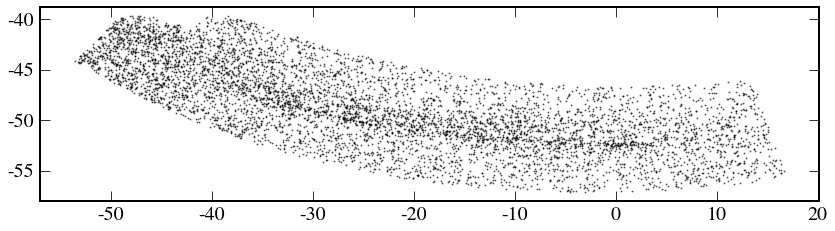

In [27]:
plt.figure(figsize=(12,6))
plt.plot(c.ra[pm_mask & cmd_mask].wrap_at(wangle), c.dec[pm_mask & cmd_mask], 'k.', ms=2, alpha=0.5)
plt.gca().set_aspect('equal')
plt.tight_layout()

### Histograms along the stream

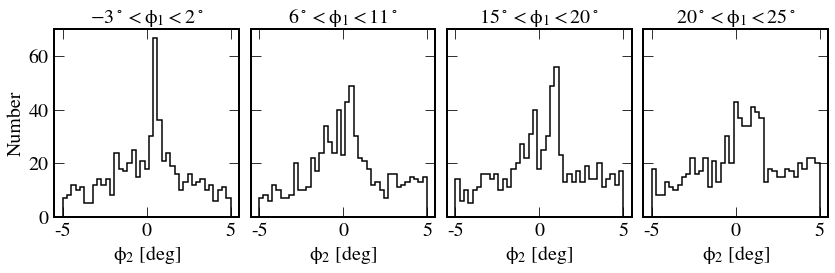

In [74]:
phi1_ranges0 = np.array([-3,6,15,20])*u.deg
phi1_ranges1 = np.array([2,11,20,25])*u.deg
by_fine = np.linspace(-5,5,40)

fig, ax = plt.subplots(1,4,figsize=(12,4.2), sharey=True, sharex=True)
for e in range(4):
    plt.sca(ax[e])
    
    ind = ((cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)>phi1_ranges0[e]) & 
    (cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)<phi1_ranges1[e]))
    
#     plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask], bins=by_fine, histtype='stepfilled', color='k', alpha=0.3,
#              lw=1.5, normed=True)
    plt.hist(cj.phi2[pm_mask & cmd_mask][ind], bins=by_fine, histtype='step', color='k', lw=1.5,
            normed=False)
    
    if e==0:
        plt.ylabel('Number')
    plt.xlabel('$\phi_2$ [deg]')
    plt.title('${:.0f}^\circ<\phi_1<{:.0f}^\circ$'.format(phi1_ranges0[e].value, phi1_ranges1[e].value),
             fontsize='medium')

plt.tight_layout(w_pad=0.5)
plt.savefig('../paper/phi2_histograms.pdf')

In [106]:
(13*u.kpc*np.tan(2*((by_fine[1] - by_fine[0])*u.deg).to(u.rad))).to(u.pc)

<Quantity 116.35839063 pc>

In [107]:
(22*u.kpc*np.tan((3.4*u.arcmin).to(u.rad))).to(u.pc)

<Quantity 21.7584451 pc>

## Figure: Properties of the stream + components

In [28]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
narrow_mask = phi1_mask & (np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg)<=0.4*u.deg)
wide_mask = (phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<-0.4*u.deg)
             & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>-2.*u.deg))
# wide_mask = (phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<-0.4*u.deg)
#              & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>-1.7*u.deg))

In [34]:
labels = ['On stream', 'Off stream', 'Dense component', 'Diffuse component']
labels_range = ['$0^\circ<\phi_2<1^\circ$', '$-4^\circ<\phi_2<-3^\circ$',
                '$|\phi_2 - \phi_{2, track}|<0.4^\circ$',
                '$-2^\circ<\phi_2 - \phi_{2, track}<-0.4^\circ$',]
# labels = ['Jhelum', 'Control']
masks_pm = [phi2_mask & pm_mask, phi2off_mask & pm_mask, narrow_mask & pm_mask, wide_mask & pm_mask]
masks_cmd = [phi2_mask & cmd_mask, phi2off_mask & cmd_mask, narrow_mask & cmd_mask, wide_mask & cmd_mask]

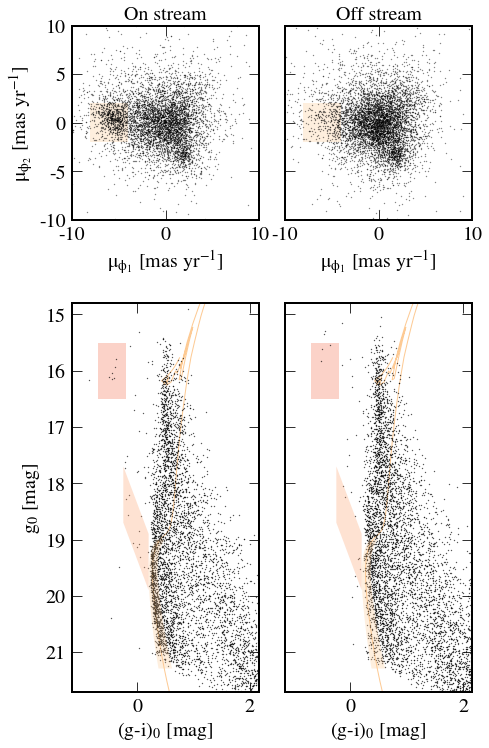

In [35]:
fig, ax = plt.subplots(2,2,figsize=(7.2,10.8), sharex='row', sharey='row', gridspec_kw = {'height_ratios':[1,2.]})

color_mem = mpl.cm.OrRd(0.3)

# proper motion diagrams
rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value

for e in range(2):
    plt.sca(ax[0][e])
    mask = masks_cmd[e]
    plt.plot(cj.pm_phi1_cosphi2[mask].to(u.mas/u.yr), cj.pm_phi2[mask].to(u.mas/u.yr), 'ko', ms=0.3, alpha=0.7,
            rasterized=True)
    
    pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color=color_mem, ec='none', alpha=0.3)
    plt.gca().add_artist(pr)
    
#     plt.gca().set_aspect('equal')
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
    if e==0:
        plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
#     plt.title('{}\n{}'.format(labels[e],labels_range[e]), fontsize='small')
    plt.title(labels[e], fontsize='medium')

# CMDs
rect_xy = [bhb_gi_min, bhb_g_min]
rect_w = bhb_gi_max - bhb_gi_min
rect_h = bhb_g_max - bhb_g_min

color_iso = mpl.cm.OrRd(0.3)
color_bs = mpl.cm.OrRd(0.45)
color_bhb = mpl.cm.OrRd(0.6)

for e in range(2):
    plt.sca(ax[1][e])
    mask = masks_pm[e]
    plt.plot(g.g0[mask] - g.i0[mask], g.g0[mask], 'ko', ms=0.3, alpha=1, rasterized=True)
    
    plt.plot(i_gi, i_g, '-', color=color_iso, lw=1, alpha=1, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')

    pm = mpl.patches.Polygon(poly_main, color=color_iso, ec='none', alpha=0.3, zorder=2, label='')
    plt.gca().add_artist(pm)

    pbs = mpl.patches.Polygon(poly_bs, color=color_bs, ec='none', alpha=0.3, zorder=2, label='')
    plt.gca().add_artist(pbs)

    pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color=color_bhb, ec='none', alpha=0.3)
    plt.gca().add_artist(pr_bhb)
    
    plt.gca().set_aspect('equal')
    plt.xlim(-0.8,1.8)
    plt.ylim(21.5, 15)
    
    plt.xlabel('(g-i)$_0$ [mag]')
    if e==0:
        plt.ylabel('$g_0$ [mag]')

plt.tight_layout(w_pad=0.1)
plt.savefig('../paper/selection.pdf', dpi=150)

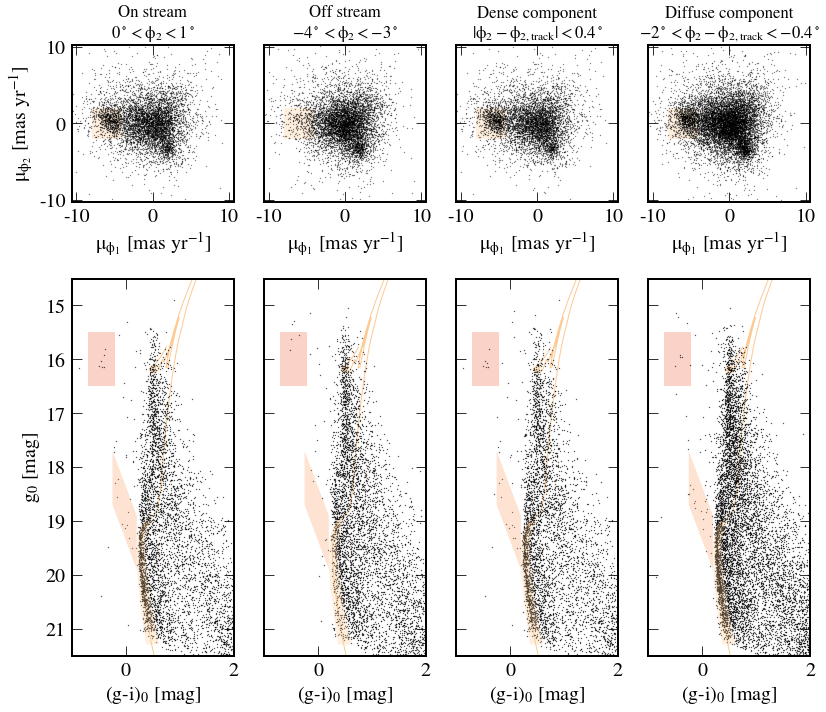

In [31]:
fig, ax = plt.subplots(2,4,figsize=(12,10.3), sharex='row', sharey='row', gridspec_kw = {'height_ratios':[1,2.4]})

color_mem = mpl.cm.OrRd(0.3)

# proper motion diagrams
rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value

for e in range(4):
    plt.sca(ax[0][e])
    mask = masks_cmd[e]
    plt.plot(cj.pm_phi1_cosphi2[mask].to(u.mas/u.yr), cj.pm_phi2[mask].to(u.mas/u.yr), 'ko', ms=0.3, alpha=0.7,
            rasterized=True)
    
    pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color=color_mem, ec='none', alpha=0.3)
    plt.gca().add_artist(pr)
    
    plt.gca().set_aspect('equal')
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
    if e==0:
        plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    plt.title('{}\n{}'.format(labels[e],labels_range[e]), fontsize='small')
#     plt.title(labels_range[e], fontsize='small')

# CMDs
rect_xy = [bhb_gi_min, bhb_g_min]
rect_w = bhb_gi_max - bhb_gi_min
rect_h = bhb_g_max - bhb_g_min

color_iso = mpl.cm.OrRd(0.3)
color_bs = mpl.cm.OrRd(0.45)
color_bhb = mpl.cm.OrRd(0.6)

for e in range(4):
    plt.sca(ax[1][e])
    mask = masks_pm[e]
    plt.plot(g.g0[mask] - g.i0[mask], g.g0[mask], 'ko', ms=0.3, alpha=1, rasterized=True)
    
    plt.plot(i_gi, i_g, '-', color=color_iso, lw=1, alpha=1, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')

    pm = mpl.patches.Polygon(poly_main, color=color_iso, ec='none', alpha=0.3, zorder=2, label='')
    plt.gca().add_artist(pm)

    pbs = mpl.patches.Polygon(poly_bs, color=color_bs, ec='none', alpha=0.3, zorder=2, label='')
    plt.gca().add_artist(pbs)

    pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color=color_bhb, ec='none', alpha=0.3)
    plt.gca().add_artist(pr_bhb)
    
    plt.gca().set_aspect('equal')
    plt.xlim(-0.8,1.8)
    plt.ylim(21.5, 14.5)
    
    plt.xlabel('(g-i)$_0$ [mag]')
    if e==0:
        plt.ylabel('$g_0$ [mag]')

plt.tight_layout(w_pad=0.1)
plt.savefig('../paper/properties.pdf', dpi=150)

### Stellar populations

In [32]:
labels = ['narrow', 'wide', 'stream']
for e, mask in enumerate([narrow_mask, wide_mask, narrow_mask | wide_mask]):
    nbs = np.sum(mask & pm_mask & bs_mask)
    sbs = np.sqrt(nbs)
    nbhb = np.sum(mask & pm_mask & bhb_mask)
    sbhb = np.sqrt(nbhb)
    
    bs2bhb = nbs/nbhb
    sbs2bhb = np.sqrt((sbs/nbhb)**2 + (nbs/nbhb**2*sbhb)**2)
    
    print('{:8s} {:4.3} +/- {:4.3}'.format(labels[e], bs2bhb, sbs2bhb))
    

narrow   2.17 +/- 1.07
wide      3.6 +/- 1.82
stream   2.82 +/- 0.989


## Figure: Orbit in the Galaxy

In [26]:
import gala.dynamics as gd
import gala.potential as gp

In [27]:
ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

In [28]:
pos = np.load('../data/jhelum_orbit_narrow.npy')
# pos = np.load('../data/jhelum_orbit.npy')

In [29]:
phi1, phi2, d, pm1, pm2, vr = pos

c_ = Jhelum(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c_.transform_to(gc_frame).cartesian)

In [30]:
dt = 0.5*u.Myr
fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=38)
model_jhelum = fit_orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [31]:
orbit_fwd = ham.integrate_orbit(w0, dt=0.5, t1=0*u.Myr, t2=7000*u.Myr)
model_fwd = orbit_fwd.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [32]:
orbit_rr = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-5000*u.Myr)
model_rr = orbit_rr.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [33]:
# orbital properties
print(orbit_fwd.eccentricity())
print(orbit_fwd.estimate_period())
print(orbit_fwd.pericenter())
print(orbit_fwd.apocenter())

0.49393345585411064
310.89069264069263 Myr
7.959229111714934 kpc
23.49603780440999 kpc


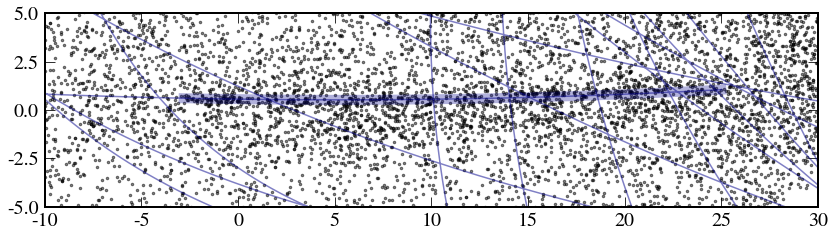

In [34]:
plt.figure(figsize=(12,12))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=5, alpha=0.5)
plt.plot(model_fwd.phi1.wrap_at(wangle), model_fwd.phi2, '-', color='darkblue', alpha=0.5)
plt.plot(model_jhelum.phi1.wrap_at(wangle), model_jhelum.phi2, '-', color='darkblue', alpha=0.3, lw=10)

plt.gca().set_aspect('equal')
plt.xlim(-10,30)
plt.ylim(-5,5)

plt.tight_layout()
plt.savefig('../plots/orbit_onsky.png')

In [98]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p2-p1)
    return (m*(phi1.wrap_at(wangle).value - p1) + d1) * u.kpc

In [99]:
i1 = np.argmin(np.abs(model_jhelum.phi1.wrap_at(wangle)))
i2 = np.argmin(np.abs(model_jhelum.phi1.wrap_at(wangle)-20*u.deg))
d1, d2 = model_jhelum.distance[i1].value, model_jhelum.distance[i2].value

print(d1, d2)

11.486617987224335 12.307236631490401


In [100]:
# adopt 13kpc
# d0 = 13
# d1 = 11.65
# d2 = 11.05

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [101]:
cgal = cj_dist.transform_to(coord.Galactocentric)
R = np.sqrt(cgal.y**2 + cgal.x**2)

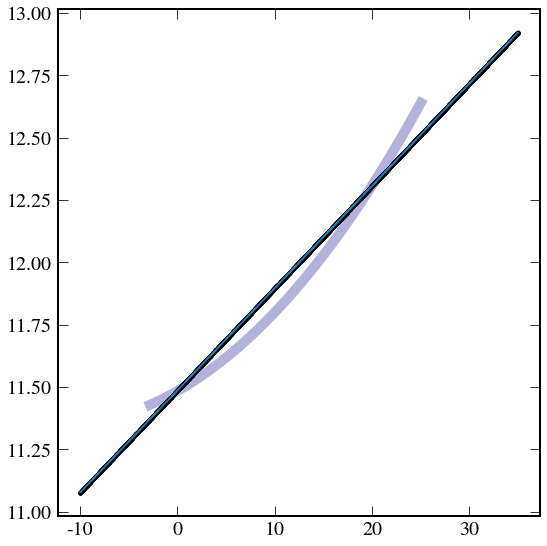

In [102]:
# plt.plot(model_rr.phi1.wrap_at(wangle), model_rr.distance, '-', color='darkblue', alpha=0.5)
plt.plot(model_jhelum.phi1.wrap_at(wangle), model_jhelum.distance, '-', color='darkblue', alpha=0.3, lw=10);
plt.plot(cj_dist.phi1.wrap_at(wangle)[pm_mask & cmd_mask], cj_dist.distance[pm_mask & cmd_mask], 'k.')
plt.plot(cj_dist.phi1.wrap_at(wangle)[pm_mask & cmd_mask],jhelum_dist(cj_dist.phi1[pm_mask & cmd_mask], d1=d1, d2=d2))

plt.tight_layout()

In [68]:
orbit_rr.pericenter(), orbit_rr.apocenter(), orbit_rr.estimate_period()

(<Quantity 7.97037429 kpc>,
 <Quantity 23.49756495 kpc>,
 <Quantity -310.68854167 Myr>)

In [117]:
torbit = orbit_rr.estimate_period()
orbits = []
for i in range(1,10):
    orbit_ = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=i*torbit)
    orbits += [orbit_]


In [151]:
ra_ind = np.array([-36.3, -8])*u.deg
dec_ind = np.array([-50.7, -64.8])*u.deg
d_ind = np.array([16.6, 17.1])*u.kpc

cind = coord.SkyCoord(ra=ra_ind, dec=dec_ind, distance=d_ind, frame='icrs')
cind_gal = cind.transform_to(coord.Galactocentric)
Rind = np.sqrt(cind_gal.y**2 + cind_gal.x**2)

In [155]:
import gala.coordinates as gc

In [156]:
indus_frame = gc.GreatCircleICRSFrame.from_endpoints(cind[0], cind[1])

In [158]:
cind_nat = cind.transform_to(indus_frame)

In [195]:
cind_line = coord.SkyCoord(phi1=np.linspace(cind_nat.phi1.wrap_at(wangle)[0], 
                                            cind_nat.phi1.wrap_at(wangle)[1],20),
                       phi2=np.zeros(20)*u.deg, distance=np.linspace(16.6,17.2,20)*u.kpc, frame=indus_frame)

In [196]:
cind_line_gal = cind_line.transform_to(coord.Galactocentric)
Rind_line = np.sqrt(cind_line_gal.y**2 + cind_line_gal.x**2)

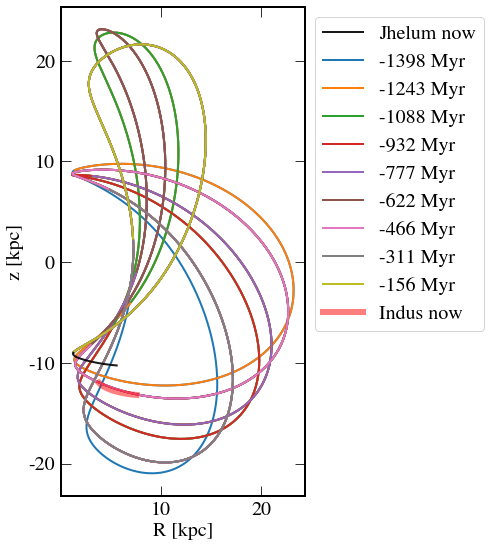

In [197]:
norb = len(orbits)
plt.plot(fit_orbit.cylindrical.rho, fit_orbit.cylindrical.z, 'k-', alpha=0.9, lw=2, label='Jhelum now')
for i in range(norb):
    plt.plot(orbits[norb-1-i].cylindrical.rho, orbits[norb-1-i].cylindrical.z, '-',
             lw=2, zorder=0, label='{:.0f}'.format(np.median(orbits[norb-1-i].t)))
#     print(i, len(orbits[norb-1-i].cylindrical.rho))

plt.plot(Rind_line, cind_line_gal.z, 'r-', label='Indus now', lw=6, alpha=0.5)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('../plots/jhelum_indus_wraps.png', dpi=200)

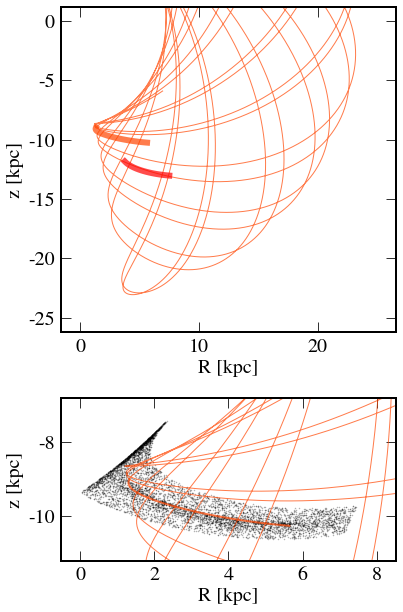

In [185]:
color = 'orangered'

fig, ax = plt.subplots(2,1,figsize=(6,9), subplot_kw={'adjustable': 'datalim'}, 
                       gridspec_kw={'height_ratios': (2,1)})

plt.sca(ax[0])
plt.plot(orbit_rr.cylindrical.rho, orbit_rr.cylindrical.z, '-', color=color, alpha=0.7, lw=1, 
         label='Jhelum (5 Gyr orbit)')
plt.plot(fit_orbit.cylindrical.rho, fit_orbit.cylindrical.z, '-', color=color, alpha=0.7, lw=6, label='Jhelum')
plt.plot(Rind_line, cind_line_gal.z, 'r-', label='Indus', lw=6, alpha=0.7)

plt.legend(loc=4, fontsize=)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,25)
plt.ylim(-25,0)
plt.gca().set_aspect('equal')

plt.sca(ax[1])
plt.plot(orbit_rr.cylindrical.rho, orbit_rr.cylindrical.z, '-', color=color, alpha=0.7, lw=1)
# plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbit.cylindrical.rho, fit_orbit.cylindrical.z, '-', color=color, alpha=0.7, lw=2)
plt.plot(R[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=1, alpha=0.3, zorder=0, rasterized=True)

plt.gca().set_aspect('equal')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,8)
plt.ylim(-11,-7)

plt.tight_layout()
plt.savefig('../paper/orbit_cyl.pdf', dpi=200)

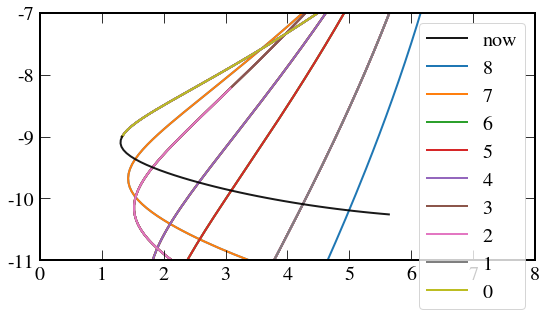

In [127]:
norb = len(orbits)
plt.plot(fit_orbit.cylindrical.rho, fit_orbit.cylindrical.z, 'k-', alpha=0.9, lw=2, label='now')
for i in range(norb):
    plt.plot(orbits[norb-1-i].cylindrical.rho, orbits[norb-1-i].cylindrical.z, '-',
             lw=2, zorder=0, label='{:d}'.format(norb-1-i))
#     print(i, len(orbits[norb-1-i].cylindrical.rho))
    
plt.legend()
plt.xlim(0,8)
plt.ylim(-11,-7)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/usr/lib64/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


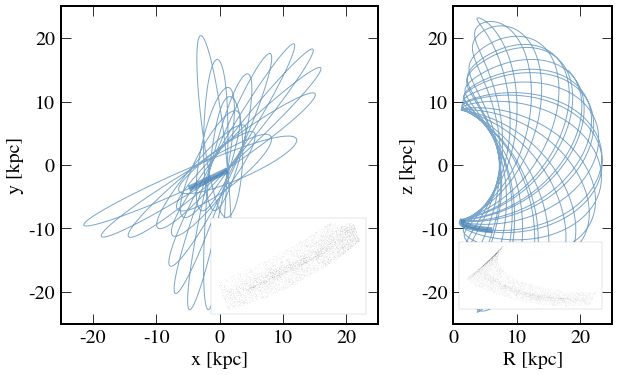

In [38]:
fig, ax = plt.subplots(1,2,figsize=(9,9), gridspec_kw = {'width_ratios':[2,1]})

orange = '#ff7f2a'

plt.sca(ax[0])
plt.plot(orbit_fwd.cartesian.x, orbit_fwd.cartesian.y, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbit.cartesian.x, fit_orbit.cartesian.y, '-', color='steelblue', alpha=0.7, lw=6)

plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.gca().set_aspect('equal')
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))

axins1 = inset_axes(plt.gca(), width='50%', height='30%',loc=4)
# plt.plot(orbit_fwd.cartesian.x, orbit_fwd.cartesian.y, '-', color='steelblue', alpha=0.2, lw=1)
plt.plot(cgal.x[pm_mask & cmd_mask], cgal.y[pm_mask & cmd_mask], 'k.', ms=0.1, alpha=0.2, zorder=1)

# plt.xlim(-5,1)
# plt.ylim(-5,0)

plt.gca().tick_params(labelleft=False, labelbottom=False, top=False, left=False, bottom=False, right=False)
for spl in plt.gca().spines:
    plt.gca().spines[spl].set_linewidth(0.1)

plt.gca().set_aspect('equal')

plt.sca(ax[1])
plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbit.cylindrical.rho, fit_orbit.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=6)

plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,25)
plt.ylim(-25,25)
plt.gca().set_aspect('equal')
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))

axins2 = inset_axes(plt.gca(), width='90%', height='24%',loc=4)
# plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.1, lw=1)
plt.plot(R[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=0.1, alpha=0.1, zorder=1)

# plt.xlim(0.5,8)
# plt.ylim(-12,-8)

plt.gca().tick_params(labelleft=False, labelbottom=False, top=False, left=False, bottom=False, right=False)
for spl in plt.gca().spines:
    plt.gca().spines[spl].set_linewidth(0.1)

plt.gca().set_aspect('equal')
# plt.axis('off')

plt.tight_layout()
plt.savefig('../paper/orbit_galactocentric.pdf')

## Figure: Model fit

In [170]:
from gala.dynamics import mockstream

In [167]:
prog_phi0 = -5*u.deg
t2 = -1*u.Gyr

model_jhelum = fit_orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)
prog_i = np.abs(model_jhelum.phi1.wrap_at(wangle) - prog_phi0).argmin()
prog_w0 = fit_orbit[prog_i][0]

In [168]:
prog_orbit = ham.integrate_orbit(prog_w0, dt=-0.1, t1=0*u.Myr, t2=t2)
prog_orbit = prog_orbit[::-1]

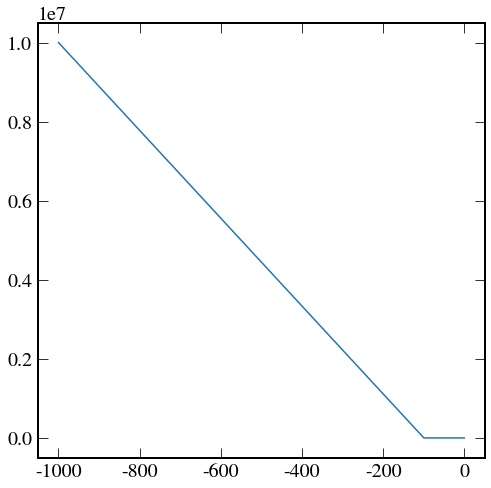

In [171]:
t_disrupt = -100*u.Myr
# t_disrupt = 0 *u.Myr
n_times = (prog_orbit.t < t_disrupt).sum()
prog_mass = np.linspace(1E7, 1E1, n_times)
prog_mass = np.concatenate((prog_mass, np.zeros(len(prog_orbit.t) - n_times))) * u.Msun
plt.plot(prog_orbit.t, prog_mass)
stream = mockstream.dissolved_fardal_stream(ham, prog_orbit, prog_mass=prog_mass, 
                                            t_disrupt=t_disrupt, release_every=1)

In [172]:
stream_jhelum = stream.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [173]:
# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = stream_jhelum.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
stream_jhelum_noreflex = coord.Galactic(rep).transform_to(Jhelum)

In [202]:
tdata = Table.read('../data/jhelum_track_narrow.fits')

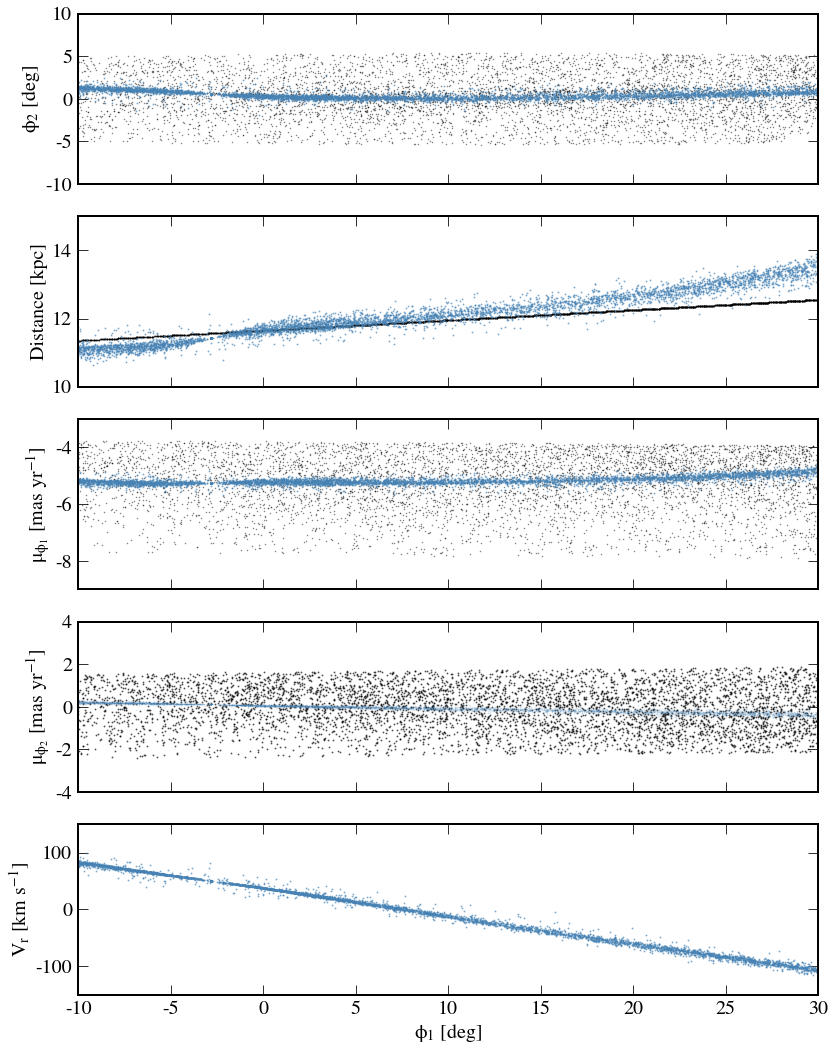

In [203]:
fig, ax = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

# ax[0].errorbar(data['phi2'][0], data['phi2'][1], data['phi2'][2], marker='o', linestyle='none', color='k')
# ax[1].errorbar(data['dist'][0], data['dist'][1], data['dist'][2], marker='o', linestyle='none', color='k')
# ax[2].errorbar(data['pm1'][0], data['pm1'][1], data['pm1'][2], marker='o', linestyle='none', color='k')
# ax[3].errorbar(data['pm2'][0], data['pm2'][1], data['pm2'][2], marker='o', linestyle='none', color='k')

plt.sca(ax[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=1, alpha=0.5)
plt.plot(stream_jhelum.phi1.wrap_at(wangle).deg, stream_jhelum.phi2.deg, '.', color='steelblue', ms=2, alpha=0.5)
plt.ylim(-10,10)
plt.xlim(-10, 30)
plt.ylabel('$\phi_2$ [deg]')
# plt.gca().set_aspect('equal')

plt.sca(ax[1])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.distance[pm_mask & cmd_mask], 'k.', ms=1, alpha=0.5)
plt.plot(stream_jhelum.phi1.wrap_at(wangle).degree, stream_jhelum.distance, '.', color='steelblue', ms=2, alpha=0.5)
plt.ylabel('Distance [kpc]')
plt.ylim(10,15)

plt.sca(ax[2])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.pm_phi1_cosphi2[pm_mask & cmd_mask].to(u.mas/u.yr), 
         'k.', ms=1, alpha=0.5)
plt.plot(stream_jhelum_noreflex.phi1.wrap_at(wangle).degree, stream_jhelum_noreflex.pm_phi1_cosphi2.to(u.mas/u.yr), 
            '.', color='steelblue', ms=2, alpha=0.5)
plt.ylabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylim(-9, -3)

plt.sca(ax[3])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.pm_phi2[pm_mask & cmd_mask].to(u.mas/u.yr),
         'k.', ms=2, alpha=0.5)
plt.plot(stream_jhelum_noreflex.phi1.wrap_at(wangle).degree, stream_jhelum_noreflex.pm_phi2.to(u.mas/u.yr), 
                '.', color='steelblue', ms=1, alpha=0.2)
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.ylim(-4,4)

plt.sca(ax[4])
plt.plot(stream_jhelum.phi1.wrap_at(wangle).degree, stream_jhelum.radial_velocity.to(u.km/u.s), 
            '.', color='steelblue', ms=2, alpha=0.5)
plt.ylabel('$V_r$ [km s$^{-1}$]')
plt.xlabel('$\phi_1$ [deg]')
plt.ylim(-150,150)

plt.tight_layout()